# DeepFool ATTACK

In [1]:
# !pip install facenet-pytorch
# !pip install Pillow
# !pip install -q tensorflow==2.0.0
# !pip install adversarial-robustness-toolbox[all]
# !pip install matplotlib

### *Import*



### initialization

In [2]:
import os
import re
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
from torch.nn import CrossEntropyLoss
import torch.nn as nn
from art.estimators.classification import PyTorchClassifier
import tensorflow as tf
from matplotlib import pyplot as plt
# Import all L-distance based attacks
from art.attacks.evasion import CarliniL2Method, CarliniL0Method, CarliniLInfMethod

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = str(device)
print(device)

c:\Users\beatr\anaconda3\envs\envai4cyber\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


In [3]:
if device in 'cuda':
    print("Import Inception.Inception")
    import inception
    resnet = inception.InceptionResnetV1(pretrained='vggface2').eval()
    resnet.classify = True
elif device == "cpu":
    print("Import Facenet.Inception")
    from facenet_pytorch import InceptionResnetV1
    resnet = InceptionResnetV1(pretrained='vggface2').eval()
    resnet.classify = True

Import Inception.Inception


In [4]:
resnet.classify = True
resnet.to(device)
fpath = tf.keras.utils.get_file('rcmalli_vggface_labels_v2.npy',
                             "https://github.com/rcmalli/keras-vggface/releases/download/v2.0/rcmalli_vggface_labels_v2.npy",
                             cache_subdir="./")
LABELS = np.load(fpath)

In [5]:
def load_image(filename):
    img = Image.open(filename)
    rsz = img.resize((160, 160))
    tns = transforms.ToTensor()(rsz)
    tns.to(device)
    return tns
model_resnet = PyTorchClassifier(resnet,input_shape=[160,160], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device) #This class implements a classifier with the PyTorch framework.


In [6]:
from SENet import SENet
from utils import get_labels
from utils import load_state_dict

senet = SENet.senet50(num_classes=8631, include_top=True)

load_state_dict(senet,'senet50_scratch_weight.pkl')
senet.eval()

model_senet = PyTorchClassifier(senet,input_shape=[224,224], loss=CrossEntropyLoss(),nb_classes=8631, device_type=device)

LABELS = get_labels()

### Untargeted Attack on all test set

In [22]:
from art.attacks.evasion import DeepFool
import os
import re
import numpy as np
from utils import load_image_NN1, load_test_image_NN2

dataset_dir = "test_set_cropped_piccolo/"
eps_range = [1e-50, 1e-30, 1e-20, 1e-10, 1e-05, 1e00]
max_iter = 5

accuracy_for_eps_resnet = []
perturbation_for_eps_resnet = []
accuracy_for_eps_senet = []
perturbation_for_eps_senet = []

total_images = 0
print("Inizio Attacco DeepFool NON-TARGETED")

# Ensure models and labels are defined and loaded
# model_resnet, model_senet, LABELS should be defined here

for eps in eps_range:
    correct_predictions_resnet = 0
    correct_predictions_senet = 0
    total_images = 0
    perturbations = []
    attack = DeepFool(classifier=model_resnet, epsilon=eps, max_iter=max_iter)

    print(f"**** Attacco con eps: {eps} ****")
    for filename in os.listdir(dataset_dir):
        if filename.endswith(".jpg") or filename.endswith(".jpeg"):
            person_path = os.path.join(dataset_dir, filename)
            test_img = load_image_NN1(person_path).numpy()
            test_images_adv = attack.generate(test_img)
            resnet_predictions = model_resnet.predict(test_images_adv)
            test_images_NN2 = load_test_image_NN2(test_images_adv)
            senet_predictions = model_senet.predict(test_images_NN2)

            correct_label = re.sub(r'_\d+_face_0\.jpg$', '', filename)
            perturbations.append(np.mean(np.abs(test_images_adv - test_img)))

            predicted_label_resnet = LABELS[np.array(resnet_predictions.argmax())]
            predicted_label_senet = LABELS[np.array(senet_predictions.argmax())]

            total_images += 1

            if correct_label in predicted_label_resnet:
                correct_predictions_resnet += 1

            if correct_label in predicted_label_senet:
                correct_predictions_senet += 1

    if total_images != 0:
        perturbation_mean = np.mean(perturbations)
        perturbation_for_eps_resnet.append(perturbation_mean)
     
        accuracy_resnet = correct_predictions_resnet / total_images
        accuracy_for_eps_resnet.append(accuracy_resnet)

        accuracy_senet = correct_predictions_senet / total_images
        accuracy_for_eps_senet.append(accuracy_senet)

        print(f"Accuracy ResNet for eps {eps}: {accuracy_resnet}")
        print(f"Accuracy SENet for eps {eps}: {accuracy_senet}")
        print(f"Average perturbation for eps {eps}: {perturbation_mean}")


Inizio Attacco DeepFool NON-TARGETED
**** Attacco con eps: 1e-50 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.29s/it]


Accuracy ResNet for eps 1e-50: 0.1
Accuracy SENet for eps 1e-50: 0.7
Average perturbation for eps 1e-50: 0.0015201657079160213
**** Attacco con eps: 1e-30 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.35s/it]


Accuracy ResNet for eps 1e-30: 0.1
Accuracy SENet for eps 1e-30: 0.7
Average perturbation for eps 1e-30: 0.0015166255179792643
**** Attacco con eps: 1e-20 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Accuracy ResNet for eps 1e-20: 0.1
Accuracy SENet for eps 1e-20: 0.7
Average perturbation for eps 1e-20: 0.0015212439466267824
**** Attacco con eps: 1e-10 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.38s/it]


Accuracy ResNet for eps 1e-10: 0.1
Accuracy SENet for eps 1e-10: 0.7
Average perturbation for eps 1e-10: 0.0015177070163190365
**** Attacco con eps: 1e-05 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]


Accuracy ResNet for eps 1e-05: 0.1
Accuracy SENet for eps 1e-05: 0.7
Average perturbation for eps 1e-05: 0.0015168546233326197
**** Attacco con eps: 1.0 ****


DeepFool: 100%|██████████| 1/1 [00:03<00:00,  3.37s/it]

Accuracy ResNet for eps 1.0: 0.1
Accuracy SENet for eps 1.0: 0.7
Average perturbation for eps 1.0: 0.0030426131561398506


In [24]:
print(accuracy_for_eps_resnet)
print(accuracy_for_eps_senet)

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
[0.7, 0.7, 0.7, 0.7, 0.7, 0.7]


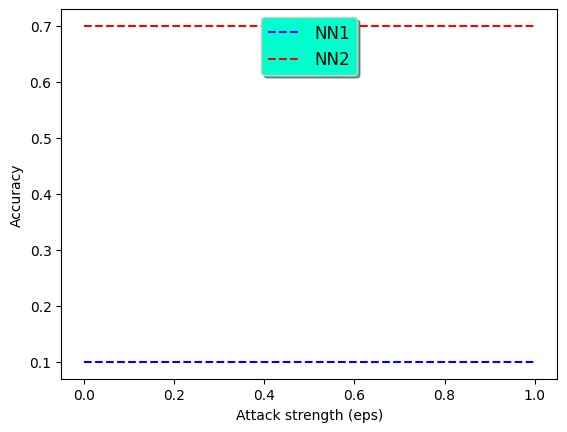

In [25]:
from matplotlib import pyplot as plt

# plot accuracy/Attack strength

fig, ax = plt.subplots()

ax.plot(np.array(eps_range), np.array(accuracy_for_eps_resnet), 'b--', label='NN1')
ax.plot(np.array(eps_range), np.array(accuracy_for_eps_senet), 'r--', label='NN2')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Accuracy')
plt.show()

In [26]:
print(accuracy_for_eps_resnet)
print("\n")
print(accuracy_for_eps_senet)


[0.1, 0.1, 0.1, 0.1, 0.1, 0.1]


[0.7, 0.7, 0.7, 0.7, 0.7, 0.7]


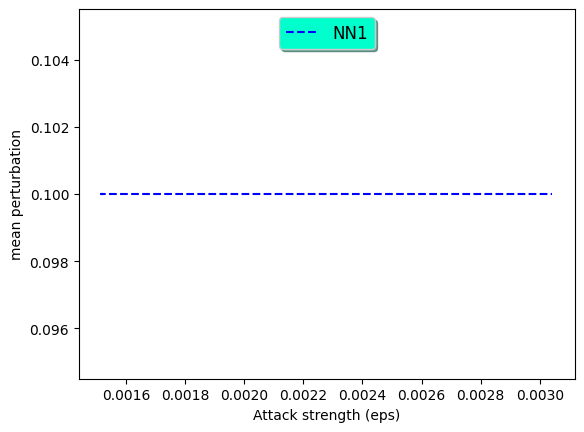

In [28]:
fig, ax = plt.subplots()
ax.plot(np.array(perturbation_for_eps_resnet), np.array(accuracy_for_eps_resnet), 'b--', label='NN1')

legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
legend.get_frame().set_facecolor('#00FFCC')

plt.xlabel('Attack strength (eps)')
plt.ylabel('mean perturbation')
plt.show()

### Single sample Untargeted attack

In [32]:
from art.attacks.evasion import DeepFool

epsilon = 0.1
max_iter = 5

attack = DeepFool(classifier=model_resnet, epsilon=epsilon, max_iter=max_iter)

In [33]:
from utils import load_image_NN1
dataset_dir = "test_set_cropped/"
filename = "Brad_Pitt_8_face_0.jpg"

person_path = os.path.join(dataset_dir, filename)
test_img = load_image_NN1(person_path)
test_img_numpy = test_img.numpy()
test_images_adv = attack.generate(test_img_numpy)


resnet_predictions = model_resnet.predict(test_images_adv)
perturbation = np.mean(np.abs((test_images_adv - test_img_numpy)))
print('Average perturbation: {:4.2f}'.format(perturbation))


test_images_NN2 = load_test_image_NN2(test_images_adv)
senet_predictions = model_senet.predict(test_images_NN2)



predicted_label_resnet = LABELS[np.array(resnet_predictions.argmax())]
predicted_label_senet = LABELS[np.array(senet_predictions.argmax())]
print("NN1{} con probabilità {}".format(predicted_label_resnet,resnet_predictions[0][resnet_predictions.argmax()]))
print("NN2{} con probabilità {}".format(predicted_label_senet,senet_predictions[0][senet_predictions.argmax()]))


DeepFool: 100%|██████████| 1/1 [00:01<00:00,  1.27s/it]

Average perturbation: 0.00
NN1 Josh_Hartnett con probabilità 11.864182472229004
NN2 Royler_Gracie con probabilità 14.641783714294434


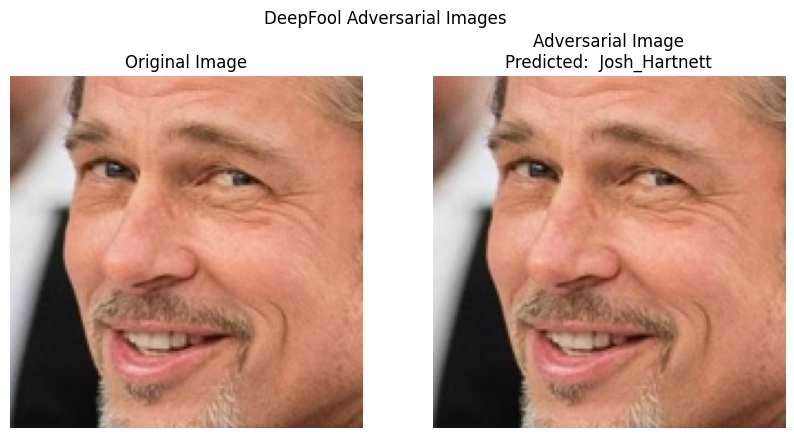

In [34]:
# Prepara le immagini per la visualizzazione
# Rimuovi la dimensione batch extra e converti nel formato channels-last
test_images_adv = np.squeeze(test_images_adv, axis=0)
test_images_adv = np.transpose(test_images_adv, (1, 2, 0))

# Converti le immagini in uint8 per la visualizzazione
if test_img_numpy.dtype != np.uint8:
    test_img_numpy = (test_img_numpy * 255).astype(np.uint8)
    test_img_numpy = np.squeeze(test_img_numpy, axis=0)  # Rimuovi la dimensione batch extra
    test_img_numpy = np.transpose(test_img_numpy, (1, 2, 0))

if test_images_adv.dtype != np.uint8:
    test_images_adv = (test_images_adv * 255).astype(np.uint8)

# Visualizza le immagini affiancate con Matplotlib
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Mostra l'immagine originale
ax1.imshow(test_img_numpy)
ax1.set_title('Original Image')
ax1.axis('off')

# Mostra l'immagine avversaria
ax2.imshow(test_images_adv)
ax2.set_title(f'Adversarial Image\nPredicted: {predicted_label_resnet}')
ax2.axis('off')

# Mostra la figura
plt.suptitle("DeepFool Adversarial Images")
plt.show()
